In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import json

import sys

sys.path.append("../")

##################################################################
os.environ["TOKENIZERS_PARALLELISM"] = "false"
# os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3,4,5,6,7"
##################################################################

import logging
from src.utils import logging_utils
from src.utils import env_utils

logger = logging.getLogger(__name__)

logging.basicConfig(
    level=logging.DEBUG,
    format=logging_utils.DEFAULT_FORMAT,
    datefmt=logging_utils.DEFAULT_DATEFMT,
    stream=sys.stdout,
)

import torch
import transformers

logger.info(f"{torch.__version__=}, {torch.version.cuda=}")
logger.info(
    f"{torch.cuda.is_available()=}, {torch.cuda.device_count()=}, {torch.cuda.get_device_name()=}"
)
logger.info(f"{transformers.__version__=}")

2025-08-17 15:34:55 __main__ INFO     torch.__version__='2.7.0+cu126', torch.version.cuda='12.6'
2025-08-17 15:34:55 __main__ INFO     torch.cuda.is_available()=True, torch.cuda.device_count()=8, torch.cuda.get_device_name()='NVIDIA A100 80GB PCIe'
2025-08-17 15:34:55 __main__ INFO     transformers.__version__='4.54.1'


In [3]:
from src.utils.training_utils import get_device_map

# model_key = "meta-llama/Llama-3.2-3B"
# model_key = "meta-llama/Llama-3.1-8B"
model_key = "meta-llama/Llama-3.3-70B-Instruct"
# model_key = "meta-llama/Llama-3.1-405B-Instruct"

# model_key = "google/gemma-2-9b-it"
# model_key = "google/gemma-3-12b-it"
# model_key = "google/gemma-2-27b-it"

# model_key = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"

# model_key = "allenai/OLMo-2-1124-7B-Instruct"
# model_key = "allenai/OLMo-7B-0424-hf"

# model_key = "Qwen/Qwen2-7B"
# model_key = "Qwen/Qwen2.5-14B-Instruct"
# model_key = "Qwen/Qwen2.5-32B-Instruct"
# model_key = "Qwen/Qwen2.5-72B-Instruct"

# model_key = "Qwen/Qwen3-1.7B"
# model_key = "Qwen/Qwen3-4B"
# model_key = "Qwen/Qwen3-8B"
# model_key = "Qwen/Qwen3-14B"
# model_key = "Qwen/Qwen3-32B"

# device_map = get_device_map(model_key, 30, n_gpus=8)
# device_map

2025-08-17 15:34:59 git.cmd DEBUG    Popen(['git', 'version'], cwd=/disk/u/arnab/Codes/Projects/retrieval/notebooks, stdin=None, shell=False, universal_newlines=False)
2025-08-17 15:34:59 git.cmd DEBUG    Popen(['git', 'version'], cwd=/disk/u/arnab/Codes/Projects/retrieval/notebooks, stdin=None, shell=False, universal_newlines=False)
2025-08-17 15:34:59 wandb.docker.auth DEBUG    Trying paths: ['/disk/u/arnab/.docker/config.json', '/disk/u/arnab/.dockercfg']
2025-08-17 15:34:59 wandb.docker.auth DEBUG    No config file found


In [4]:
from src.models import ModelandTokenizer

# from transformers import BitsAndBytesConfig

mt = ModelandTokenizer(
    model_key=model_key,
    torch_dtype=torch.bfloat16,
    # device_map=device_map,
    device_map="auto",
    # quantization_config = BitsAndBytesConfig(
    #     # load_in_4bit=True
    #     load_in_8bit=True
    # )
    attn_implementation="eager",
)

2025-08-17 15:35:01 src.models WARNING  meta-llama/Llama-3.3-70B-Instruct not found in /disk/u/arnab/Codes/Models
If not found in cache, model will be downloaded from HuggingFace to cache directory
2025-08-17 15:35:01 urllib3.connectionpool DEBUG    Starting new HTTPS connection (1): huggingface.co:443
2025-08-17 15:35:01 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/config.json HTTP/1.1" 200 0
2025-08-17 15:35:01 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
2025-08-17 15:35:01 urllib3.connectionpool DEBUG    https://huggingface.co:443 "GET /api/models/meta-llama/Llama-3.3-70B-Instruct/tree/main/additional_chat_templates?recursive=False&expand=False HTTP/1.1" 404 64


Loading checkpoint shards:   0%|          | 0/30 [00:00<?, ?it/s]

2025-08-17 15:35:47 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/generation_config.json HTTP/1.1" 200 0
2025-08-17 15:35:47 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/custom_generate/generate.py HTTP/1.1" 404 0
2025-08-17 15:35:48 src.models INFO     loaded model <meta-llama/Llama-3.3-70B-Instruct> | size: 134570.516 MB | dtype: torch.bfloat16 | device: cuda:0


In [6]:
# file_path = os.path.join(
#     env_utils.DEFAULT_DATA_DIR,
#     "selection",
#     # "profession.json"
#     # "nationality.json"
#     "objects.json",
# )

# with open(file_path, "r") as f:
#     temp = json.load(f)

# for cat in temp["categories"]:
#     temp["categories"][cat] = [obj.capitalize() for obj in temp["categories"][cat]]

# with open(file_path, "w") as f:
#     json.dump(temp, f, indent=4)


In [7]:
from src.selection.data import SelectOneTask, SelectOrderTask

#################################################################################
# TASK_CLS = SelectOrderTask
# prompt_template_idx = 1
TASK_CLS = SelectOneTask
prompt_template_idx = 3
N_DISTRACTORS = 5
OPTION_STYLE = "single_line"
#################################################################################

select_task = TASK_CLS.load(
    path=os.path.join(
        env_utils.DEFAULT_DATA_DIR, 
        "selection", 
        # "profession.json"
        # "nationality.json"
        "objects.json"
    )
)

print(select_task)

SelectOneTask: (different objects)
Categories: fruit(15), vehicle(15), furniture(15), animal(15), music instrument(15), clothing(15), electronics(15), sport equipment(15), kitchen appliance(15), vegetable(14), building(15), office supply(15), bathroom item(15), flower(15), tree(15), jewelry(15)



In [8]:
sample = select_task.get_random_sample(
    mt = mt,
    option_style=OPTION_STYLE,
    prompt_template_idx=prompt_template_idx,
    obj_idx=2,
    # category="actor",
    # category="Brazil"
    category="fruit",
    filter_by_lm_prediction=False,
)

print(sample)
print(sample.prompt())

Blueberry -> Orange (2): ['Shirt', 'Blender', 'Orange', 'Accordion', 'Train', 'Router']
Options: Shirt, Blender, Orange, Accordion, Train, Router.
Which among these objects mentioned above is a fruit?
Answer:


In [9]:
from src.selection.utils import verify_correct_option
# sample.prompt_template = select_prof.prompt_templates[3]
print(f'"{sample.prompt()}"', ">>", sample.obj)

verify_correct_option(
    mt=mt,
    target=sample.obj,
    options=sample.options,
    input=sample.prompt()
)

"Options: Shirt, Blender, Orange, Accordion, Train, Router.
Which among these objects mentioned above is a fruit?
Answer:" >> Orange


(True,
 [PredictedToken(token=' Orange', prob=0.8203125, logit=22.75, token_id=22725, metadata=None),
  PredictedToken(token=' The', prob=0.076171875, logit=20.375, token_id=578, metadata=None),
  PredictedToken(token=' An', prob=0.052490234375, logit=20.0, token_id=1556, metadata=None),
  PredictedToken(token=' Among', prob=0.0247802734375, logit=19.25, token_id=22395, metadata=None),
  PredictedToken(token=' OR', prob=0.0037994384765625, logit=17.375, token_id=2794, metadata=None)],
 OrderedDict([(22725,
               (1,
                PredictedToken(token=' Orange', prob=0.8203125, logit=22.75, token_id=22725, metadata=None))),
              (11683,
               (38,
                PredictedToken(token=' Acc', prob=9.5367431640625e-05, logit=13.6875, token_id=11683, metadata=None))),
              (55807,
               (274,
                PredictedToken(token=' Shirt', prob=1.5348196029663086e-06, logit=9.5625, token_id=55807, metadata=None))),
              (88668,
       

In [10]:
from src.functional import generate_with_patch

gen = generate_with_patch(
    mt = mt,
    inputs = sample.prompt(),
    max_new_tokens=20,
    do_sample=False,
    remove_prefix=True
)[0]
print(f'"{gen}"', ">>", sample.obj)

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


" Orange.
Explanation: Orange is a type of fruit. The other options are not fruits. Shirt is" >> Orange


In [11]:
mt.n_layer, mt.config.num_attention_heads

(80, 64)

In [12]:
HEADS = [
    (33, 45),
    (33, 18),
    (34, 1),
    (34, 6),
    (34, 7),
    (35, 19),
    (39, 40),
    (42, 30),
    (47, 18),
    (52, 58),
]
# HEADS = [(35, 19)]


# with open("optimized_heads.json", "r") as f:
#     HEADS = json.load(f)

# with open("category_wise_heads.json", "r") as f:
#     category_wise_heads = json.load(f)
# HEADS = [
#     (layer_idx, head_idx)
#     for layer_idx, head_idx, score in category_wise_heads["all"][:100]
# ]
# HEADS = [(layer_idx, head_idx) for layer_idx, head_idx in HEADS if layer_idx < 61]


print(len(HEADS))

10


2025-08-17 15:36:52 matplotlib DEBUG    matplotlib data path: /disk/u/arnab/miniconda3/envs/connection/lib/python3.11/site-packages/matplotlib/mpl-data
2025-08-17 15:36:52 matplotlib DEBUG    CONFIGDIR=/disk/u/arnab/.config/matplotlib
2025-08-17 15:36:52 matplotlib DEBUG    interactive is False
2025-08-17 15:36:52 matplotlib DEBUG    platform is linux
2025-08-17 15:36:52 matplotlib DEBUG    CACHEDIR=/disk/u/arnab/.cache/matplotlib
2025-08-17 15:36:52 matplotlib.font_manager DEBUG    Using fontManager instance from /disk/u/arnab/.cache/matplotlib/fontlist-v390.json
2025-08-17 15:36:53 matplotlib.pyplot DEBUG    Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-08-17 15:36:53 matplotlib.pyplot DEBUG    Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-08-17 15:36:53 matplotlib.font_manager DEBUG    findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2025-08-17 15:36:53 matplotlib.font

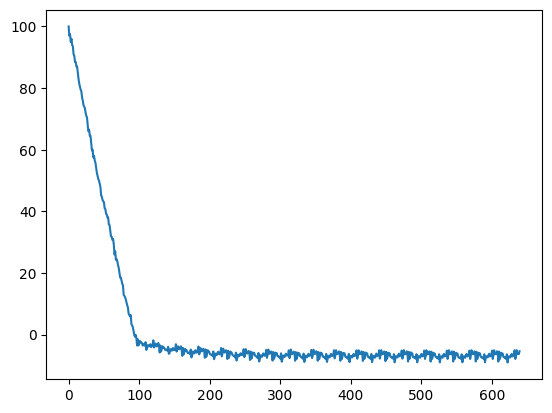

In [13]:
from matplotlib import pyplot as plt
import numpy as np

optimized_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection/optimized_heads",
    mt.name.split("/")[-1],
    f"{select_task.task_name}.npz"
)

optimization_results = np.load(optimized_path, allow_pickle=True)
plt.plot(optimization_results["losses"])
plt.show()

66


(True, True)

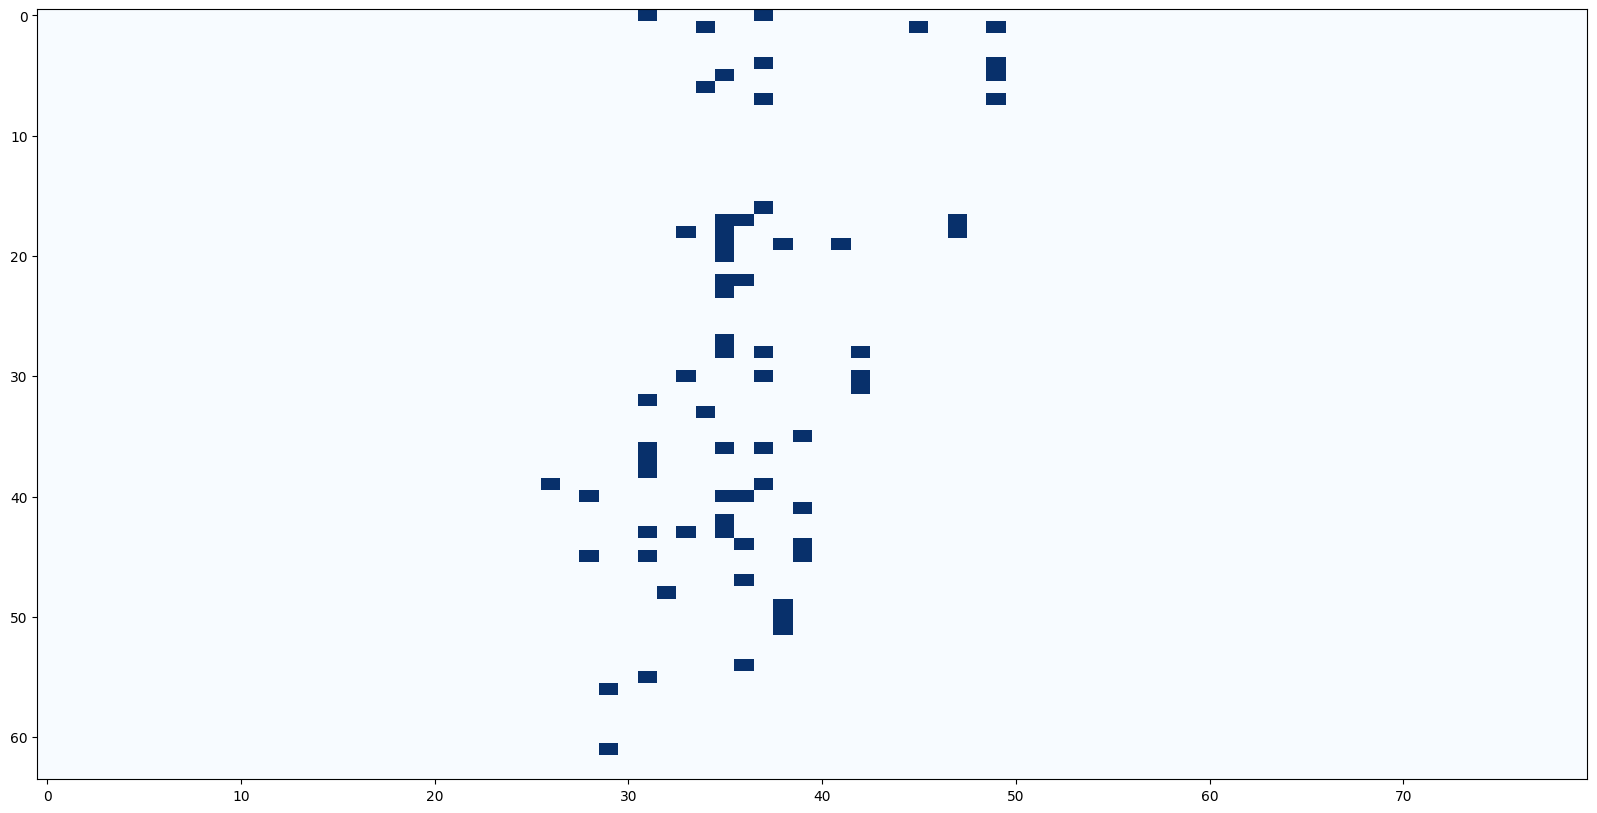

In [15]:
plt.figure(figsize=(20, 10))

optimal_head_mask = torch.tensor(optimization_results["optimal_mask"]).to(torch.float32)
optimal_head_mask[50:, :] = 0.0

plt.imshow(
    optimal_head_mask.T.numpy(),
    cmap="Blues",
    aspect="auto",
    vmin=0,
    vmax=1,
)

heads_selected = torch.nonzero(optimal_head_mask > 0.5, as_tuple=False).tolist()
heads_selected = [
    (layer_idx, head_idx) for layer_idx, head_idx in heads_selected if layer_idx < 50
]
print(len(heads_selected))

HEADS = heads_selected

(35, 19) in HEADS, (35, 19) in heads_selected

In [16]:
from src.attention import get_attention_matrices
from src.selection.functional import (
    verify_head_patterns,
    get_patches_to_verify_independent_enrichment,
)

attn_pattern = verify_head_patterns(
    prompt=sample.prompt(option_style="single_line"),
    options=sample.options,
    pivot=sample.subj,
    mt=mt,
    heads=HEADS,
)

0 patches to ablate possible answer information from options
2025-08-17 15:37:35 src.selection.functional DEBUG    Predictions: ['" Orange"[22725] (p=0.820, logit=22.750)', '" The"[578] (p=0.076, logit=20.375)', '" An"[1556] (p=0.052, logit=20.000)', '" Among"[22395] (p=0.025, logit=19.250)', '" orange"[19087] (p=0.004, logit=17.375)']
2025-08-17 15:37:35 src.selection.functional INFO     Combined attention matrix for all heads


In [30]:
import copy
import random
from src.selection.utils import KeyedSet, get_first_token_id, verify_correct_option
from src.selection.data import SelectionSample
from src.functional import predict_next_token
from src.tokens import prepare_input

######################################################################
N_DISTRACTORS = 5
######################################################################


@torch.inference_mode()
def get_counterfactual_samples_within_task(
    task: SelectOneTask | SelectOrderTask = select_task,
    patch_category: str | None = None,
    clean_category: str | None = None,
    shuffle_clean_options: bool = False,
    clean_prompt_template_idx=2,
    patch_prompt_template_idx=3,
    clean_option_style="numbered",
    patch_option_style="single_line",
    filter_by_lm_prediction: bool = True,
    distinct_options: bool = False,
    n_distractors: int = N_DISTRACTORS,
):
    categories = list(task.category_wise_examples.keys())
    if patch_category is None:
        patch_category = random.choice(categories)

    patch_subj, patch_obj = random.sample(
        task.category_wise_examples[patch_category], 2
    )
    logger.info(
        f"Patch category: {patch_category}, subject: {patch_subj}, object: {patch_obj}"
    )

    if clean_category is None:
        clean_category = random.choice(list(set(categories) - {patch_category}))

    clean_options = task.category_wise_examples[clean_category]
    random.shuffle(clean_options)

    clean_subj, clean_obj = random.sample(
        (
            KeyedSet(clean_options, mt.tokenizer) - KeyedSet([patch_obj], mt.tokenizer)
        ).values,
        2,
    )
    logger.info(
        f"Clean category: {clean_category}, subject: {clean_subj}, object: {clean_obj}"
    )

    if distinct_options is False:
        patch_type_obj = patch_obj
        clean_type_obj = clean_obj
    else:
        patch_type_obj = random.choice(
            (
                KeyedSet(task.category_wise_examples[patch_category], mt.tokenizer)
                - KeyedSet([patch_obj], mt.tokenizer)
            ).values
        )
        clean_type_obj = random.choice(
            (
                KeyedSet(task.category_wise_examples[clean_category], mt.tokenizer)
                - KeyedSet([clean_obj], mt.tokenizer)
            ).values
        )

    patch_must_have_options = [patch_obj, clean_type_obj]
    clean_must_have_options = [clean_obj, patch_type_obj]

    logger.info(f"{patch_must_have_options=}")
    logger.info(f"{clean_must_have_options=}")
    logger.info(f"{clean_type_obj=}")
    logger.info(f"{patch_type_obj=}")

    patch_distractors = []
    other_categories = random.sample(
        list(set(categories) - {patch_category, clean_category}),
        k=n_distractors - (len(patch_must_have_options)) + 1,
    )

    for other_category in other_categories:
        other_examples = task.category_wise_examples[other_category]
        random.shuffle(other_examples)
        other_examples = KeyedSet(other_examples, mt.tokenizer)
        patch_distractors.append(
            random.choice(
                (
                    other_examples
                    - KeyedSet(
                        patch_must_have_options + patch_distractors,
                        tokenizer=mt.tokenizer,
                    )
                ).values
            )
        )

    patch_options = patch_must_have_options + patch_distractors
    random.shuffle(patch_options)
    patch_obj_idx = patch_options.index(patch_obj)
    logger.info(f"{patch_obj_idx=} | {patch_options}")

    if distinct_options is not True:
        clean_options = copy.deepcopy(patch_options)
        if shuffle_clean_options:
            # Useful for the pointer experiments
            while (
                clean_options.index(clean_obj) == patch_obj_idx
                or clean_options.index(patch_type_obj) == patch_obj_idx
            ):
                random.shuffle(clean_options)
        clean_obj_idx = clean_options.index(clean_obj)

    else:
        other_categories = random.sample(
            list(set(categories) - {patch_category, clean_category}),
            k=N_DISTRACTORS - (len(clean_must_have_options)) + 1,
        )
        clean_distractors = []
        for other_category in other_categories:
            other_examples = task.category_wise_examples[other_category]
            random.shuffle(other_examples)
            other_examples = KeyedSet(other_examples, mt.tokenizer)
            clean_distractors.append(
                random.choice(
                    (
                        other_examples
                        - KeyedSet(
                            clean_must_have_options + clean_distractors,
                            tokenizer=mt.tokenizer,
                        )
                    ).values
                )
            )
        clean_options = clean_must_have_options + clean_distractors
        random.shuffle(clean_options)
        while clean_options.index(clean_obj) == patch_obj_idx:
            random.shuffle(clean_options)
        clean_obj_idx = clean_options.index(clean_obj)

    logger.info(f"{clean_obj_idx=} | {clean_options}")

    print(f"{type(task)=}")
    if isinstance(task, SelectOrderTask):
        patch_metadata = {
            "track_type_obj_idx": clean_obj_idx,
            "track_type_obj": patch_options[clean_obj_idx],
            "track_type_obj_token_id": get_first_token_id(
                patch_options[clean_obj_idx], mt.tokenizer, prefix=" "
            ),
        }
        clean_metadata = {
            "track_type_obj_idx": patch_obj_idx,
            "track_type_obj": clean_options[patch_obj_idx],
            "track_type_obj_token_id": get_first_token_id(
                clean_options[patch_obj_idx], mt.tokenizer, prefix=" "
            ),
        }
    elif isinstance(task, SelectOneTask):
        patch_metadata = {
            "track_category": clean_category,
            "track_type_obj": clean_type_obj,
            "track_type_obj_idx": patch_options.index(clean_type_obj),
            "track_type_obj_token_id": get_first_token_id(
                clean_type_obj, mt.tokenizer, prefix=" "
            ),
        }
        clean_metadata = {
            "track_category": patch_category,
            "track_type_obj": patch_type_obj,
            "track_type_obj_idx": clean_options.index(patch_type_obj),
            "track_type_obj_token_id": get_first_token_id(
                patch_type_obj, mt.tokenizer, prefix=" "
            ),
        }
    else:
        raise NotImplementedError(f"Unsupported task type: {type(task)}")

    patch_sample = SelectionSample(
        subj=patch_subj,
        obj=patch_obj,
        answer=patch_obj,
        obj_idx=patch_obj_idx,
        ans_token_id=get_first_token_id(patch_obj, mt.tokenizer, prefix=" "),
        options=patch_options,
        category=patch_category,
        metadata=patch_metadata,
        prompt_template = task.prompt_templates[patch_prompt_template_idx],
        default_option_style=patch_option_style,
    )
    clean_sample = SelectionSample(
        subj=clean_subj,
        obj=clean_obj,
        answer=clean_obj,
        obj_idx=clean_obj_idx,
        ans_token_id=get_first_token_id(clean_obj, mt.tokenizer, prefix=" "),
        options=clean_options,
        category=clean_category,
        metadata=clean_metadata,
        prompt_template = task.prompt_templates[clean_prompt_template_idx],
        default_option_style=clean_option_style,
    )

    if filter_by_lm_prediction:
        test_samples = [patch_sample, clean_sample]
        if distinct_options is True:
            clean_sample_2 = copy.deepcopy(patch_sample)
            clean_sample_2.options = clean_options
            clean_sample_2.obj = clean_sample.metadata["track_type_obj"]
            clean_sample_2.obj_idx = clean_sample.metadata["track_type_obj_idx"]
            clean_sample_2.ans_token_id = clean_sample.metadata[
                "track_type_obj_token_id"
            ]
            test_samples.append(clean_sample_2)

        for sample in test_samples:
            tokenized = prepare_input(tokenizer=mt, prompts=sample.prompt())
            is_correct, predictions, track_options = verify_correct_option(
                mt=mt, target=sample.obj, options=sample.options, input=tokenized
            )
            sample.metadata["tokenized"] = tokenized.data
            logger.info(sample.prompt())
            logger.info(
                f"{sample.subj} | {sample.category} -> {sample.obj} | pred={[str(p) for p in predictions]}"
            )
            if not is_correct:
                logger.error(
                    f'Prediction mismatch: {track_options[list(track_options.keys())[0]]}["{mt.tokenizer.decode(predictions[0].token_id)}"] != {sample.ans_token_id}["{mt.tokenizer.decode(sample.ans_token_id)}"]'
                )
                return get_counterfactual_samples_within_task(
                    task=task,
                    patch_category=patch_category,
                    clean_category=clean_category,
                    shuffle_clean_options=shuffle_clean_options,
                    clean_prompt_template_idx=clean_prompt_template_idx,
                    patch_prompt_template_idx=patch_prompt_template_idx,
                    clean_option_style=clean_option_style,
                    patch_option_style=patch_option_style,
                    filter_by_lm_prediction=filter_by_lm_prediction,
                    distinct_options=distinct_options,
                    n_distractors=n_distractors,
                )
            sample.prediction = predictions

    return patch_sample, clean_sample

In [51]:
patch_sample, clean_sample = get_counterfactual_samples_within_task(
    # patch_category="politician",
    # clean_category="actor",
    task=select_task,
    patch_category="fruit",
    clean_category="vehicle",
    filter_by_lm_prediction=True,
    distinct_options=True,
    n_distractors = N_DISTRACTORS,
)

clean_sample.metadata

2025-08-17 15:56:32 __main__ INFO     Patch category: fruit, subject: Pear, object: Cherry


2025-08-17 15:56:32 __main__ INFO     Clean category: vehicle, subject: Van, object: Helicopter
2025-08-17 15:56:32 __main__ INFO     patch_must_have_options=['Cherry', 'Ambulance']
2025-08-17 15:56:32 __main__ INFO     clean_must_have_options=['Helicopter', 'Apple']
2025-08-17 15:56:32 __main__ INFO     clean_type_obj='Ambulance'
2025-08-17 15:56:32 __main__ INFO     patch_type_obj='Apple'
2025-08-17 15:56:32 __main__ INFO     patch_obj_idx=5 | ['Shampoo', 'Smartwatch', 'Ambulance', 'Apartment', 'Ring', 'Cherry']
2025-08-17 15:56:32 __main__ INFO     clean_obj_idx=1 | ['Apple', 'Helicopter', 'Dolphin', 'Hickory', 'Food processor', 'Pendant']
type(task)=<class 'src.selection.data.SelectOneTask'>
2025-08-17 15:56:32 __main__ INFO     Options: Shampoo, Smartwatch, Ambulance, Apartment, Ring, Cherry.
Which among these objects mentioned above is a fruit?
Answer:
2025-08-17 15:56:32 __main__ INFO     Pear | fruit -> Cherry | pred=['" Cherry"[45805] (p=0.812, logit=22.250)', '" The"[578] (p=

{'track_category': 'fruit',
 'track_type_obj': 'Apple',
 'track_type_obj_idx': 0,
 'track_type_obj_token_id': 8325,
 'tokenized': {'input_ids': tensor([[128000,  23956,   1665,    505,    279,   2768,   1160,    374,    264,
             7458,   5380,     64,     13,   8325,    198,     65,     13,  16183,
            88323,    198,     66,     13,  96096,    198,     67,     13,  79028,
              683,    198,     68,     13,  12369,  18121,    198,     69,     13,
            81501,    198,  16533,     25]], device='cuda:0'),
  'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
           1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0')}}

In [52]:
# order_sample_1 = SelectionSample(
#     subj="random",
#     category="test_order",
#     options=["Bike", "Apple", "Bed", "Dog", "Monitor", "Theater"],
#     obj="Apple",
#     obj_idx=1,
#     prompt_template="<_options_>\nWhat is the third item in the list?\nAnswer:",
#     answer="Apple",
# )

# order_sample_2 = SelectionSample(
#     subj="random",
#     category="test_order",
#     options=["Cat", "Chair", "Bus", "Phone", "Library", "Orange"],
#     obj="Phone",
#     obj_idx=3,
#     prompt_template="<_options_>\nWhat is the fifth item in the list?\nAnswer:",
#     answer="Phone",
# )
len(HEADS)

66

In [53]:
from src.functional import generate_with_patch

# patch_sample.options[patch_sample.obj_idx] = "Screw"
# patch_sample.options[patch_sample.obj_idx] = patch_sample.obj
# patch_sample.default_option_style = "single_line"
# clean_sample.default_option_style = "numbered"

for sample in [patch_sample, clean_sample]:
# for sample in [order_sample_1, order_sample_2]:
    print(sample.prompt(), ">>", sample.obj)
    attn_pattern = verify_head_patterns(
        prompt=sample.prompt(),
        options=sample.options,
        pivot=sample.subj,
        mt=mt,
        heads=HEADS,
        generate_full_answer=True,
        query_index=-1
    )

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Options: Shampoo, Smartwatch, Ambulance, Apartment, Ring, Cherry.
Which among these objects mentioned above is a fruit?
Answer: >> Cherry
0 patches to ablate possible answer information from options
2025-08-17 15:56:41 src.selection.functional DEBUG    Generated full answer: " Cherry.
Explanation: Cherry is a fruit. The other options are not fruits. Shampoo is a hair care product, Smartwatch is an electronic device"
2025-08-17 15:56:42 src.selection.functional DEBUG    Predictions: ['" Cherry"[45805] (p=0.812, logit=22.250)', '" The"[578] (p=0.097, logit=20.125)', '" Among"[22395] (p=0.041, logit=19.250)', '" A"[362] (p=0.022, logit=18.625)', '" ("[320] (p=0.003, logit=16.500)']
2025-08-17 15:56:42 src.selection.functional INFO     Combined attention matrix for all heads


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Which object from the following list is a vehicle?
a. Apple
b. Helicopter
c. Dolphin
d. Hickory
e. Food processor
f. Pendant
Answer: >> Helicopter
0 patches to ablate possible answer information from options
2025-08-17 15:56:45 src.selection.functional DEBUG    Generated full answer: " b. Helicopter
Explanation: A helicopter is a type of aircraft that is used for transportation, making it a vehicle. The other options are not"
2025-08-17 15:56:45 src.selection.functional DEBUG    Predictions: ['" b"[293] (p=0.770, logit=22.500)', '" The"[578] (p=0.104, logit=20.500)', '" A"[362] (p=0.043, logit=19.625)', '" Hel"[16183] (p=0.026, logit=19.125)', '" ("[320] (p=0.023, logit=19.000)']
2025-08-17 15:56:45 src.selection.functional INFO     Combined attention matrix for all heads


## Validation of the patching effect

In [74]:
from src.functional import free_gpu_cache
free_gpu_cache()
validation_set = []
validation_limit = 256

while len(validation_set) < validation_limit:
    patch, clean = get_counterfactual_samples_within_task(
        filter_by_lm_prediction=True,
        distinct_options=True,
        n_distractors=N_DISTRACTORS,
    )
    validation_set.append((clean, patch))

2025-08-17 16:29:29 __main__ INFO     Patch category: flower, subject: Carnation, object: Daffodil
2025-08-17 16:29:29 __main__ INFO     Clean category: vehicle, subject: Airplane, object: Tractor
2025-08-17 16:29:29 __main__ INFO     patch_must_have_options=['Daffodil', 'Train']
2025-08-17 16:29:29 __main__ INFO     clean_must_have_options=['Tractor', 'Orchid']
2025-08-17 16:29:29 __main__ INFO     clean_type_obj='Train'
2025-08-17 16:29:29 __main__ INFO     patch_type_obj='Orchid'
2025-08-17 16:29:29 __main__ INFO     patch_obj_idx=3 | ['Dresser', 'Pants', 'Train', 'Daffodil', 'Zucchini', 'Spruce']
2025-08-17 16:29:29 __main__ INFO     clean_obj_idx=1 | ['Theater', 'Tractor', 'Refrigerator', 'Jeans', 'Eraser', 'Orchid']
type(task)=<class 'src.selection.data.SelectOneTask'>
2025-08-17 16:29:29 __main__ INFO     Options: Dresser, Pants, Train, Daffodil, Zucchini, Spruce.
Which among these objects mentioned above is a flower?
Answer:
2025-08-17 16:29:29 __main__ INFO     Carnation | flo

In [76]:
from src.selection.optimization import validate_q_proj_ie_on_sample_pair
from src.tokens import find_token_range

clean, patch = copy.deepcopy(validation_set[38])
# clean.default_option_style="numbered"
# patch.default_option_style="numbered"
# clean, patch = train_set[18]
# clean, patch = clean_sample, patch_sample
# clean, patch = order_sample_2, order_sample_1
# patch, clean = order_sample_1, order_sample_2
# failed_case = failed_cases[0]
# clean = failed_case["clean_sample"]
# patch = failed_case["patch_sample"]

# patch.options[patch.obj_idx] = "Mango"
# patch.options = ["#"]
print(clean.prompt(), ">>", clean.obj)
print(patch.prompt(), ">>", patch.obj)

clean_ques = (
    find_token_range(
        tokenizer=mt.tokenizer, string=clean.prompt(), substring="?", occurrence=-1
    )[1]
    - 1
)

patch_ques = (
    find_token_range(
        tokenizer=mt.tokenizer, string=patch.prompt(), substring="?", occurrence=-1
    )[1]
    - 1
)

logger.debug(
    f"{patch_ques=} | \"{mt.tokenizer.decode(patch.metadata['tokenized']['input_ids'][0][patch_ques])}\""
)
logger.debug(
    f"{clean_ques=} | \"{mt.tokenizer.decode(clean.metadata['tokenized']['input_ids'][0][clean_ques])}\""
)

validation_result = validate_q_proj_ie_on_sample_pair(
    mt=mt,
    clean_sample=clean,
    patch_sample=patch,
    # heads=HEADS,
    heads=heads_selected,
    # heads=[(35, 19)],
    query_indices={
        patch_ques: clean_ques, 
        -2: -2, 
        -1: -1
    },
    verify_head_behavior_on=-1,
    # ablate_possible_ans_info_from_options=True,
    # amplification_scale=1.5,
)

clean_obj = clean.ans_token_id
target_obj = clean.metadata["track_type_obj_token_id"]

logger.debug(f"clean obj: {mt.tokenizer.decode(clean_obj)}")
logger.debug(f"target obj: {mt.tokenizer.decode(target_obj)}")

before_intervention = {
    "clean_rank": validation_result["clean_track"][clean_obj][0],
    "clean_logit": validation_result["clean_track"][clean_obj][1].logit,
    "target_rank": validation_result["clean_track"][target_obj][0],
    "target_logit": validation_result["clean_track"][target_obj][1].logit,
}

after_intervention = {
    "clean_rank": validation_result["int_track"][clean_obj][0],
    "clean_logit": validation_result["int_track"][clean_obj][1].logit,
    "target_rank": validation_result["int_track"][target_obj][0],
    "target_logit": validation_result["int_track"][target_obj][1].logit,
}

clean_rank_delta = after_intervention["clean_rank"] - before_intervention["clean_rank"]
target_rank_delta = (
    after_intervention["target_rank"] - before_intervention["target_rank"]
)
logger.info(
    f"Clean Prediction Rank Change: {before_intervention['clean_rank']} -> {after_intervention['clean_rank']} | Delta: {clean_rank_delta} "
)
logger.info(
    f"Target Prediction Rank Change: {before_intervention['target_rank']} -> {after_intervention['target_rank']} | Delta: {target_rank_delta} "
)

clean_logit_delta = (
    after_intervention["clean_logit"] - before_intervention["clean_logit"]
)
target_logit_delta = (
    after_intervention["target_logit"] - before_intervention["target_logit"]
)
logger.info(
    f"Clean Prediction Logit Change: {before_intervention['clean_logit']:.4f} -> {after_intervention['clean_logit']:.4f} | Delta: {clean_logit_delta:.4f} "
)
logger.info(
    f"Target Prediction Logit Change: {before_intervention['target_logit']:.4f} -> {after_intervention['target_logit']:.4f} | Delta: {target_logit_delta:.4f} "
)

Which object from the following list is a vehicle?
a. Mixer
b. Folder
c. Car
d. Cow
e. Cufflink
f. Peony
Answer: >> Car
Options: Truck, Pen, Comb, Xylophone, Blender, Router.
Which among these objects mentioned above is a kitchen appliance?
Answer: >> Blender
2025-08-17 16:32:56 __main__ DEBUG    patch_ques=28 | "?
"
2025-08-17 16:32:56 __main__ DEBUG    clean_ques=10 | "?
"
2025-08-17 16:32:56 src.selection.optimization INFO     Verifying head behavior...
2025-08-17 16:32:56 src.selection.optimization INFO     Clean Sample >> Ans: Car


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


0 patches to ablate possible answer information from options
2025-08-17 16:33:00 src.selection.functional DEBUG    Generated full answer: " c. Car
Explanation: A vehicle is a means of transporting people or goods. A car is a type of vehicle, so it is the correct"
2025-08-17 16:33:00 src.selection.functional DEBUG    Predictions: ['" c"[272] (p=0.664, logit=21.500)', '" The"[578] (p=0.148, logit=20.000)', '" ("[320] (p=0.054, logit=19.000)', '" A"[362] (p=0.048, logit=18.875)', '" Car"[3341] (p=0.026, logit=18.250)']
2025-08-17 16:33:00 src.selection.functional INFO     Combined attention matrix for all heads


2025-08-17 16:33:00 src.selection.optimization INFO     Patch Sample >> Ans: Blender


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


0 patches to ablate possible answer information from options
2025-08-17 16:33:03 src.selection.functional DEBUG    Generated full answer: " Blender.
Explanation: Blender is a kitchen appliance used for mixing, pureeing, or emulsifying food and other substances. It is a common appliance"
2025-08-17 16:33:04 src.selection.functional DEBUG    Predictions: ['" Blender"[88668] (p=0.918, logit=23.000)', '" The"[578] (p=0.031, logit=19.625)', '" A"[362] (p=0.019, logit=19.125)', '" Among"[22395] (p=0.017, logit=19.000)', '" blender"[62895] (p=0.002, logit=16.750)']
2025-08-17 16:33:04 src.selection.functional INFO     Combined attention matrix for all heads


2025-08-17 16:33:04 src.selection.optimization INFO     Caching the query states for the 66 heads
2025-08-17 16:33:04 src.selection.optimization INFO     patch_prediction=['" Blender"[88668] (p=0.918, logit=23.000)', '" The"[578] (p=0.031, logit=19.625)', '" A"[362] (p=0.019, logit=19.125)', '" Among"[22395] (p=0.017, logit=19.000)', '" blender"[62895] (p=0.002, logit=16.750)']
2025-08-17 16:33:04 src.selection.optimization INFO     clean run
2025-08-17 16:33:04 src.selection.optimization INFO     clean_prediction=['" c"[272] (p=0.664, logit=21.500)', '" The"[578] (p=0.148, logit=20.000)', '" ("[320] (p=0.054, logit=19.000)', '" A"[362] (p=0.048, logit=18.875)', '" Car"[3341] (p=0.026, logit=18.250)']
2025-08-17 16:33:04 src.selection.optimization INFO     clean_track=OrderedDict([(3341, (5, PredictedToken(token=' Car', prob=0.0257568359375, logit=18.25, token_id=3341, metadata=None))), (356, (6, PredictedToken(token=' C', prob=0.015625, logit=17.75, token_id=356, metadata=None))), (22

2025-08-17 16:33:04 src.selection.optimization INFO     int_prediction=['" a"[264] (p=0.586, logit=21.250)', '" Mixer"[72392] (p=0.147, logit=19.875)', '" The"[578] (p=0.115, logit=19.625)', '" A"[362] (p=0.054, logit=18.875)', '" ("[320] (p=0.037, logit=18.500)']
2025-08-17 16:33:04 src.selection.optimization INFO     int_track=OrderedDict([(72392, (2, PredictedToken(token=' Mixer', prob=0.1474609375, logit=19.875, token_id=72392, metadata=None))), (356, (20, PredictedToken(token=' C', prob=0.000728607177734375, logit=14.5625, token_id=356, metadata=None))), (3341, (45, PredictedToken(token=' Car', prob=0.00011157989501953125, logit=12.6875, token_id=3341, metadata=None))), (36943, (175, PredictedToken(token=' Folder', prob=6.288290023803711e-06, logit=9.8125, token_id=36943, metadata=None))), (22607, (317, PredictedToken(token=' Cow', prob=2.175569534301758e-06, logit=8.75, token_id=22607, metadata=None))), (5250, (356, PredictedToken(token=' Pe', prob=1.9222497940063477e-06, logit=8

In [91]:
from tqdm.auto import tqdm

validation_results = []
for clean_sample, patch_sample in tqdm(validation_set):
    patch_ques = (
        find_token_range(
            tokenizer=mt.tokenizer,
            string=patch_sample.prompt(),
            substring="?",
            occurrence=-1,
        )[1]
        - 1
    )
    clean_ques = (
        find_token_range(
            tokenizer=mt.tokenizer,
            string=clean_sample.prompt(),
            substring="?",
            occurrence=-1,
        )[1]
        - 1
    )
    logger.debug(
        f"{patch_ques=} | \"{mt.tokenizer.decode(patch_sample.metadata['tokenized']['input_ids'][0][patch_ques])}\""
    )
    logger.debug(
        f"{clean_ques=} | \"{mt.tokenizer.decode(clean_sample.metadata['tokenized']['input_ids'][0][clean_ques])}\""
    )

    result = validate_q_proj_ie_on_sample_pair(
        mt=mt,
        clean_sample=clean_sample,
        patch_sample=patch_sample,
        # heads=HEADS,
        heads = heads_selected,
        query_indices={
            # patch_ques: clean_ques,
            # -2: -2,
            -1: -1
        },
        verify_head_behavior_on=None,
    )
    validation_results.append(result)
    print("=" * 80)

  0%|          | 0/256 [00:00<?, ?it/s]

2025-08-17 16:41:19 __main__ DEBUG    patch_ques=30 | "?
"
2025-08-17 16:41:19 __main__ DEBUG    clean_ques=10 | "?
"
2025-08-17 16:41:19 src.selection.optimization INFO     Caching the query states for the 66 heads
2025-08-17 16:41:19 src.selection.optimization INFO     patch_prediction=['" D"[423] (p=0.809, logit=22.375)', '" The"[578] (p=0.085, logit=20.125)', '" A"[362] (p=0.046, logit=19.500)', '" Among"[22395] (p=0.031, logit=19.125)', '" d"[294] (p=0.008, logit=17.750)']
2025-08-17 16:41:19 src.selection.optimization INFO     clean run
2025-08-17 16:41:19 src.selection.optimization INFO     clean_prediction=['" b"[293] (p=0.766, logit=22.625)', '" The"[578] (p=0.133, logit=20.875)', '" A"[362] (p=0.030, logit=19.375)', '" ("[320] (p=0.023, logit=19.125)', '" Tr"[1183] (p=0.020, logit=19.000)']
2025-08-17 16:41:19 src.selection.optimization INFO     clean_track=OrderedDict([(1183, (5, PredictedToken(token=' Tr', prob=0.0203857421875, logit=19.0, token_id=1183, metadata=None))), (

In [92]:
before_intervention = []
after_intervention = []

for intervention_result in validation_results:
    clean_sample = intervention_result["clean_sample"]
    patch_sample = intervention_result["patch_sample"]

    clean_obj = clean_sample.ans_token_id
    target_obj = clean_sample.metadata["track_type_obj_token_id"]

    before_intervention.append({
        "clean_rank": intervention_result["clean_track"][clean_obj][0],
        "clean_logit": intervention_result["clean_track"][clean_obj][1].logit,
        "target_rank": intervention_result["clean_track"][target_obj][0],
        "target_logit": intervention_result["clean_track"][target_obj][1].logit,
    })

    after_intervention.append({
        "clean_rank": intervention_result["int_track"][clean_obj][0],
        "clean_logit": intervention_result["int_track"][clean_obj][1].logit,
        "target_rank": intervention_result["int_track"][target_obj][0],
        "target_logit": intervention_result["int_track"][target_obj][1].logit,
    })

In [93]:
import numpy as np

clean_rank_delta = [
    after["clean_rank"] - before["clean_rank"]
    for before, after in zip(before_intervention, after_intervention)
]
target_rank_delta = [
    after["target_rank"] - before["target_rank"]
    for before, after in zip(before_intervention, after_intervention)
]

clean_rank_delta, target_rank_delta = np.array(clean_rank_delta), np.array(
    target_rank_delta
)
print(f"clean_rank_delta: {clean_rank_delta.mean():.4f} ± {clean_rank_delta.std():.4f}")
print(
    f"target_rank_delta: {target_rank_delta.mean():.4f} ± {target_rank_delta.std():.4f}"
)

clean_rank_after_intervention = [after["clean_rank"] for after in after_intervention]
clean_rank_after_intervention = np.array(clean_rank_after_intervention)
print(
    f"clean_rank_after_intervention: {clean_rank_after_intervention.mean():.4f} ± {clean_rank_after_intervention.std():.4f}"
)

target_rank_after_intervention = [after["target_rank"] for after in after_intervention]
target_rank_after_intervention = np.array(target_rank_after_intervention)
print(
    f"target_rank_after_intervention: {target_rank_after_intervention.mean():.4f} ± {target_rank_after_intervention.std():.4f}"
)

clean_rank_delta: 136.1016 ± 367.0804
target_rank_delta: -1292.2969 ± 3073.5875
clean_rank_after_intervention: 140.1992 ± 366.9977
target_rank_after_intervention: 70.6758 ± 412.1745


In [94]:
clean_logit_delta = [
    after["clean_logit"] - before["clean_logit"]
    for before, after in zip(before_intervention, after_intervention)
]
target_logit_delta = [
    after["target_logit"] - before["target_logit"]
    for before, after in zip(before_intervention, after_intervention)
]
clean_logit_delta, target_logit_delta = np.array(clean_logit_delta), np.array(target_logit_delta)
print(f"clean_logit_delta: {clean_logit_delta.mean():.4f} ± {clean_logit_delta.std():.4f}")
print(f"target_logit_delta: {target_logit_delta.mean():.4f} ± {target_logit_delta.std():.4f}")

clean_logit_after_intervention = [
    after["clean_logit"]
    for after in after_intervention
]
clean_logit_after_intervention = np.array(clean_logit_after_intervention)
print(f"clean_logit_after_intervention: {clean_logit_after_intervention.mean():.4f} ± {clean_logit_after_intervention.std():.4f}")

target_logit_after_intervention = [
    after["target_logit"]
    for after in after_intervention
]
target_logit_after_intervention = np.array(target_logit_after_intervention)
print(f"target_logit_after_intervention: {target_logit_after_intervention.mean():.4f} ± {target_logit_after_intervention.std():.4f}")

clean_logit_delta: -5.1643 ± 3.4388
target_logit_delta: 8.3275 ± 3.4445
clean_logit_after_intervention: 13.5251 ± 3.4033
target_logit_after_intervention: 17.2004 ± 3.1939


In [95]:
top_1 = sum([1 for after in after_intervention if after["target_rank"] == 1])
top_1 / len(after_intervention)

0.0078125

In [97]:
counter_patch_type_top_option = 0
failed_cases = []

for intervention_result in validation_results:
    clean_sample = intervention_result["clean_sample"]
    patch_sample = intervention_result["patch_sample"]
    int_track = intervention_result["int_track"]
    clean_track = intervention_result["clean_track"]
    if (
        int_track[list(int_track.keys())[0]][1].token_id
        == clean_sample.metadata["track_type_obj_token_id"]
    ): 
        counter_patch_type_top_option += 1
    else:
        failed_cases.append(
            {
                "clean_sample": clean_sample,
                "patch_sample": patch_sample,
                "int_track": int_track,
                "clean_track": clean_track,
            }
        )

top_1_accuracy = counter_patch_type_top_option / len(validation_results)
print(
    f"Counterfactual patching accuracy: {top_1_accuracy:.4f} ({counter_patch_type_top_option}/{len(validation_results)})"
)

Counterfactual patching accuracy: 0.6016 (154/256)


In [84]:
for failed_case in failed_cases[:20]:
    clean_sample = failed_case["clean_sample"]
    patch_sample = failed_case["patch_sample"]
    int_track = failed_case["int_track"]
    clean_track = failed_case["clean_track"]

    print("Clean Sample:")
    print(clean_sample.prompt(), ">>", clean_sample.obj)

    print("-" * 100)
    print(
        "Track: ",
        clean_sample.metadata["track_type_obj"], " | Token"
        f"\"{mt.tokenizer.decode(clean_sample.metadata['track_type_obj_token_id'])}\"",
    )
    print("Clean:", clean_sample.obj, f"(Token: {mt.tokenizer.decode(clean_sample.ans_token_id)})")
    print("-" * 100)

    clean_track = [pred for tok_id, (rank, pred) in clean_track.items()]
    print(f"Clean Track: {json.dumps([str(pred) for pred in clean_track], indent=4)}")

    int_track = [pred for tok_id, (rank, pred) in int_track.items()]
    print(
        f"Intervened Track: {json.dumps([str(pred) for pred in int_track], indent=4)}"
    )
    print("=" * 100)

Clean Sample:
Which object from the following list is a jewelry?
a. Brooch
b. Television
c. Orchid
d. Mirror
e. Racket
f. Chair
Answer: >> Brooch
----------------------------------------------------------------------------------------------------
Track:  Television  | Token" Television"
Clean: Brooch (Token:  Bro)
----------------------------------------------------------------------------------------------------
Clean Track: [
    "\" Bro\"[6031] (p=0.043, logit=20.000)",
    "\" R\"[432] (p=0.000, logit=11.125)",
    "\" Orch\"[55405] (p=0.000, logit=9.375)",
    "\" Television\"[41445] (p=0.000, logit=8.562)",
    "\" Mirror\"[34954] (p=0.000, logit=8.500)",
    "\" Chair\"[16478] (p=0.000, logit=7.312)"
]
Intervened Track: [
    "\" Bro\"[6031] (p=0.140, logit=20.750)",
    "\" Television\"[41445] (p=0.000, logit=13.000)",
    "\" R\"[432] (p=0.000, logit=12.312)",
    "\" Mirror\"[34954] (p=0.000, logit=11.250)",
    "\" Orch\"[55405] (p=0.000, logit=8.000)",
    "\" Chair\"[16478